In [1]:
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
from collections import defaultdict 
import yaml
import json
import gin
from typing import Dict, Any

import lib_analysis 


In [2]:
from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [4]:
TOY_DF = lib_analysis.read_problem(Path('../data'), 'toy')

In [5]:
def row_multimap(df: pd.DataFrame, f) -> pd.DataFrame:
    def f_map(row):
        ret = f(row)
        ret = ([r.to_frame().T for r in ret])
        ret = pd.concat(ret)        
        return ret 
    
    rows = []
    for r in df.apply(f_map, axis=1):
        rows.append(r)
    df_new = pd.concat(rows).reset_index(drop=True)
    return df_new

In [6]:
def expand_network(df: pd.DataFrame, order_by_column: str) -> pd.DataFrame:
    def f_map(row):
        n_networks = 2
        if row[order_by_column][0] <= row[order_by_column][1]:
            net_0 = 0
            net_1 = 1
        else:
            net_0 = 1
            net_1 = 0
            
        ret = [
            row.copy() for _ in range(n_networks)
        ]
        
        ret[0]['network'] = 'net0'
        ret[1]['network'] = 'net1'
        
        for k, v in row.items():
            if type(v) == type([]) or type(v) == type((0, 0)):
                ret[0][k] = v[net_0]
                ret[1][k] = v[net_1] 
        # assert ret[0][order_by_column] <= ret[1][order_by_column]
        return ret
    return row_multimap(df, f_map)

In [7]:
def split_train_test(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def f_map(row):
        train_row = row.copy()
        train_row['distribution'] = 'train'
        test_row = row.copy()
        test_row['distribution'] = 'test'
        
        train_row[column] = row[f'train_{column}']
        test_row[column] = row[f'test_{column}']
        
        return [train_row, test_row]
        ret = [r.to_frame().T for r in ret]
        ret = pd.concat(ret)        
        return ret
    df = row_multimap(df, f_map)
    df = df.drop([f'train_{column}', f'test_{column}'], axis=1)
    df[column] = df[column].apply(pd.to_numeric)
    return df

def wnc(df: pd.DataFrame, column: str) -> pd.DataFrame:
    df[column] = df[column].apply(pd.to_numeric)
    return df

In [8]:
import plotly.express as px
import plotly.graph_objects as go


def concat_columns_for_color(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    df['color'] = df[columns].agg(lambda xs: '_'.join(map(str, xs)), axis=1)
    return df


def prepare_for_plotting(df: pd.DataFrame, column: str, groupby: List[str] = ['color', 'lambda']) -> pd.DataFrame:
    df = wnc(df, column)
    df = df[[column, *groupby]]
    g = df.groupby(groupby)
    
    
    mean = g.quantile(0.5, interpolation='linear')
    top = (g.quantile(0.9, interpolation='nearest') - mean).rename(columns={column: 'top'})
    bot = (mean - g.quantile(0.1, interpolation='nearest')).rename(columns={column: 'bottom'})
    ret = mean.join(top).join(bot)
    ret = ret.reset_index()
    return ret


def plot_with_color(fig: go.Figure, df: pd.DataFrame, column: str) -> None:
    for color in df['color'].unique():
        fdf = df[df['color'] == color]
        fig.add_trace(go.Scatter(
            x=fdf['lambda'],
            y=fdf[column],
            error_y=dict(
                type='data',
                symmetric=False,
                array=fdf['top'],
                arrayminus=fdf['bottom']),
            name=color,
            )
        )
        
def end_to_end_plot(fig: go.Figure, df: pd.DataFrame, data_column: str, group_by_columns: List[str], title_text:str) -> go.Figure:
    df = concat_columns_for_color(wnc(df, data_column), group_by_columns)    
    df = prepare_for_plotting(df, data_column)
    plot_with_color(fig, df, data_column)
    fig.update_layout(
        xaxis_type="log",
        title_text=title_text
    )
    return fig

In [9]:
tabs = []
for indep in sorted(TOY_DF["indep"].unique()):
    figs = []
    
    df = TOY_DF[TOY_DF["indep"] == indep].copy()
    fig = end_to_end_plot(
        go.Figure(),
        expand_network(df, "norm"),
        "norm",
        ["network", "kernel"],
        "Norms of weights",
    )
    figs.append(fig)

    fig = end_to_end_plot(
        go.Figure(), df, "cos", ["kernel"], "Cos of weights"
    )
    figs.append(fig)

    fig = end_to_end_plot(
        go.Figure(),
        split_train_test(df, "diversity_loss"),
        "diversity_loss",
        ["kernel", "distribution"],
        "Diversity loss",
    )
    figs.append(fig)

    fig = end_to_end_plot(
        go.Figure(),
        split_train_test(expand_network(df, "test_accuracy"), "accuracy"),
        "accuracy",
        ["kernel", "distribution", "network"],
        "Accuracy",
    )
    figs.append(fig)
    
    tabs.append(dcc.Tab(label=f"{indep} independence", children=[
        dcc.Graph(figure=f) for f in figs
    ]))

    
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    dcc.Tabs(tabs)
])
app.run_server(mode="inline")


0     None
1     None
2     None
3     None
4     None
      ... 
91    None
92    None
93    None
94    None
95    None
Length: 96, dtype: object

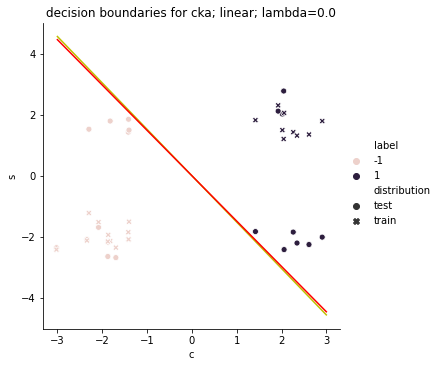

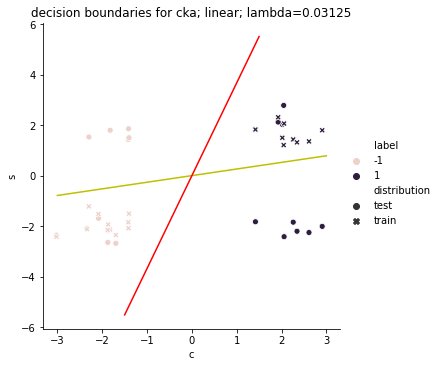

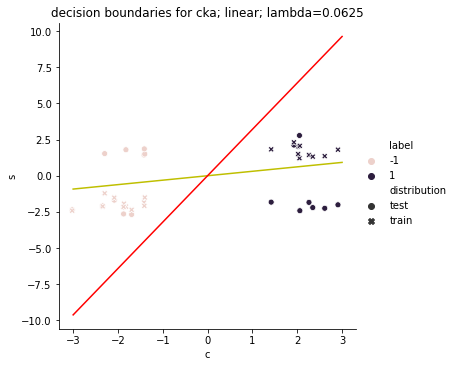

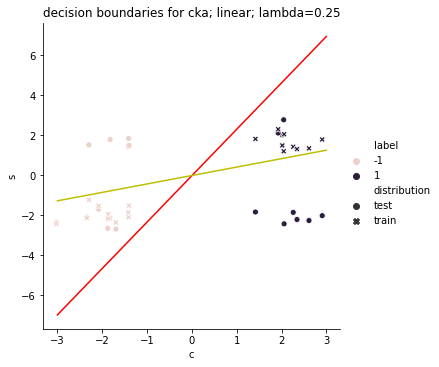

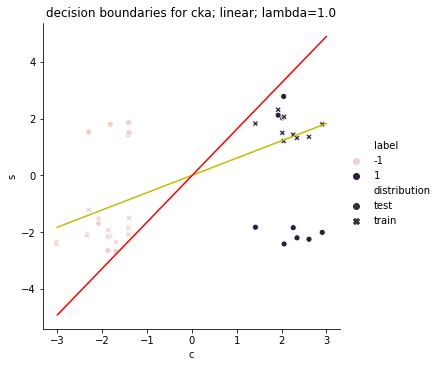

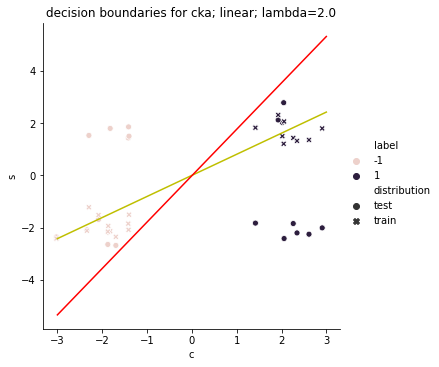

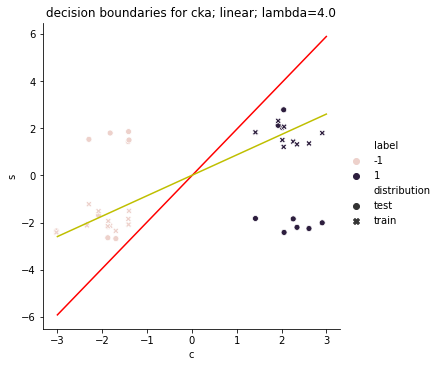

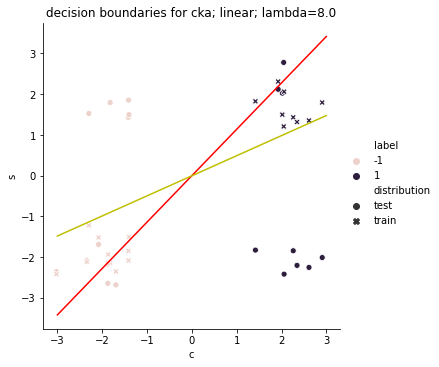

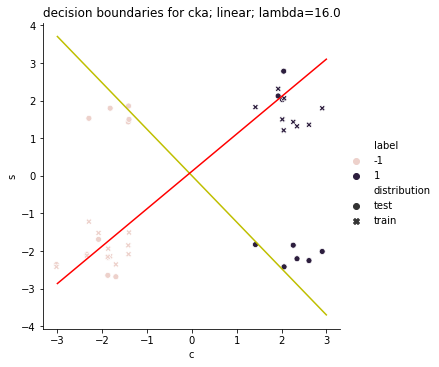

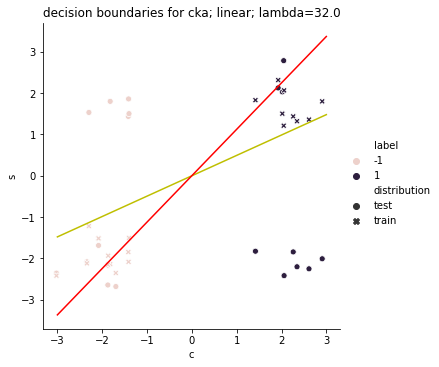

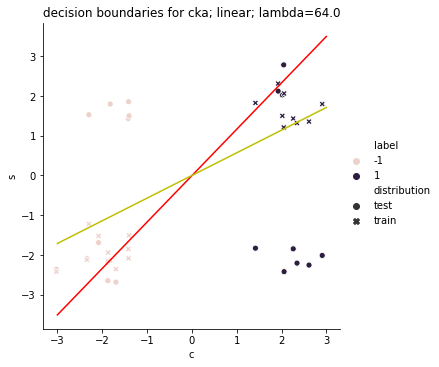

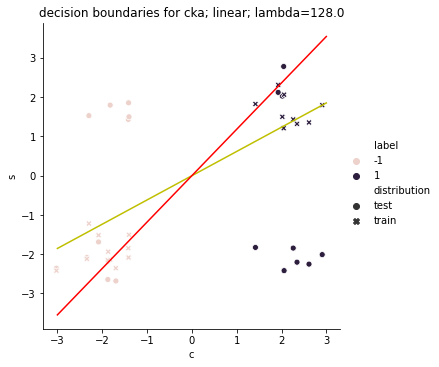

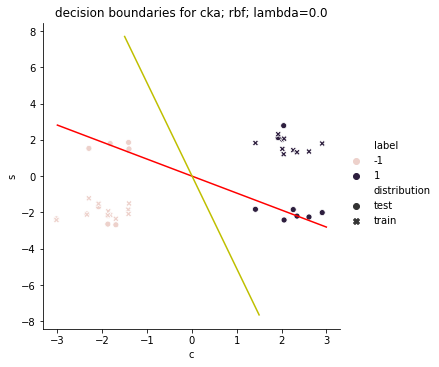

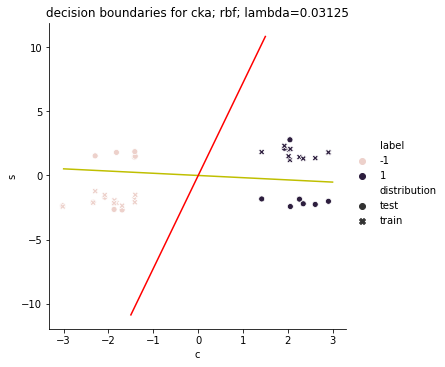

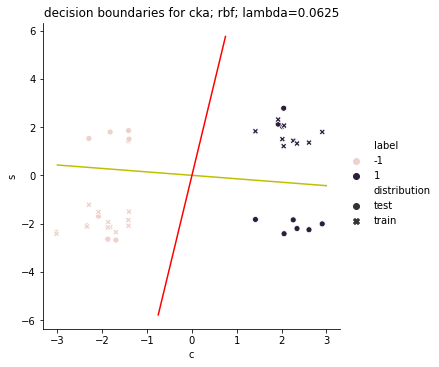

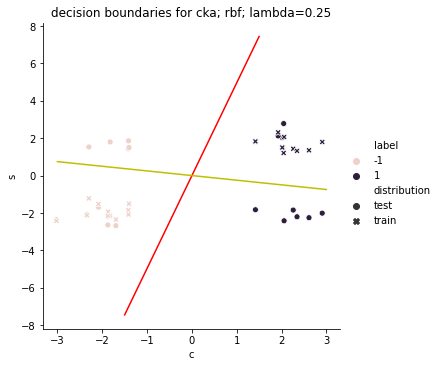

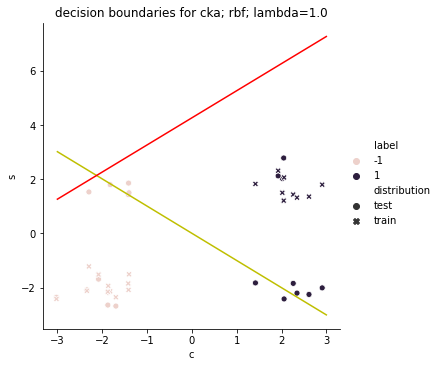

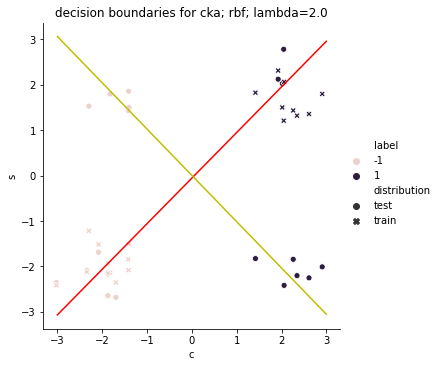

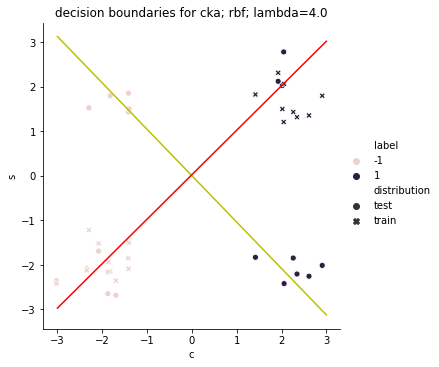

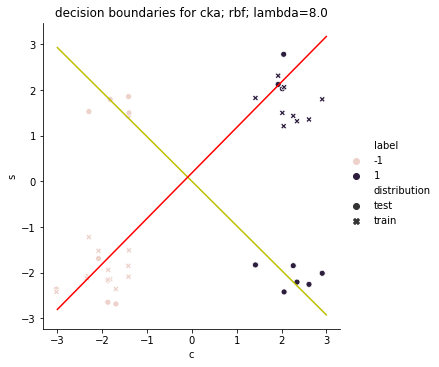

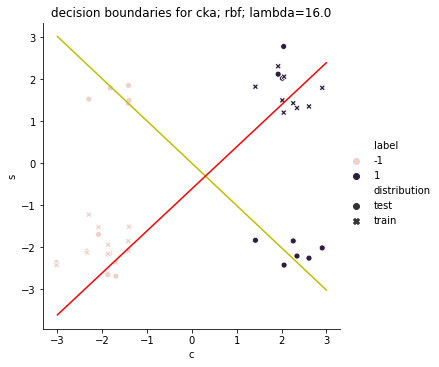

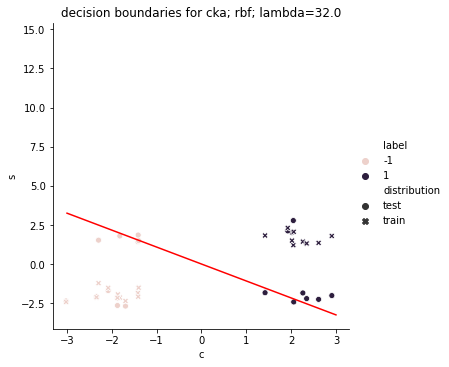

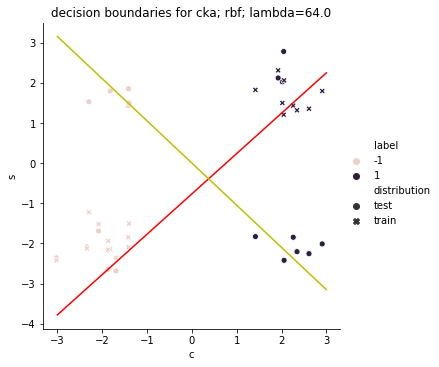

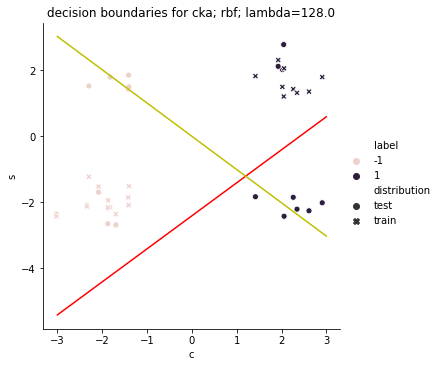

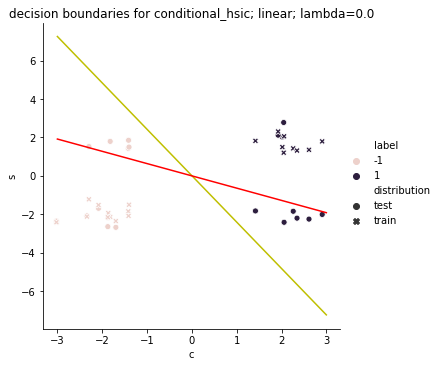

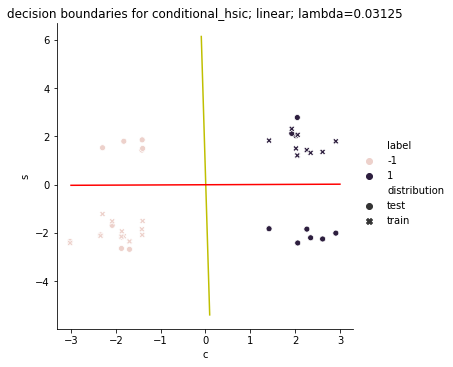

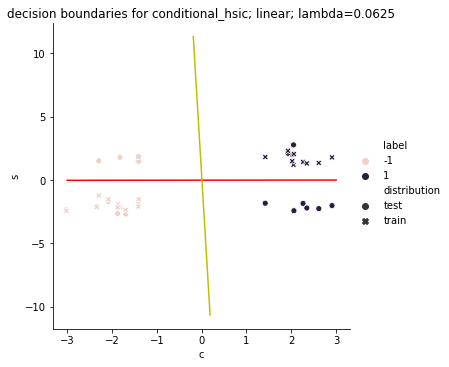

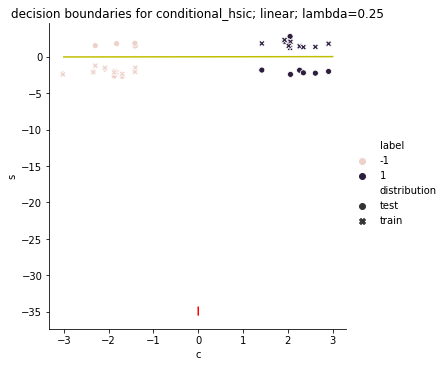

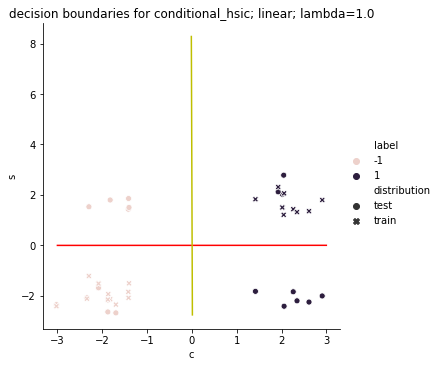

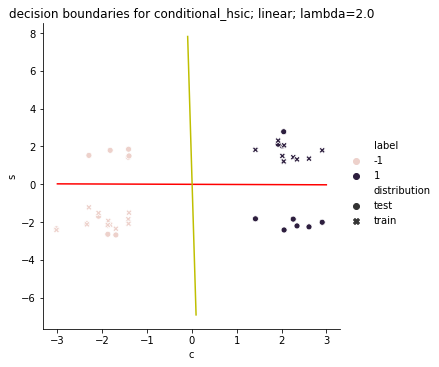

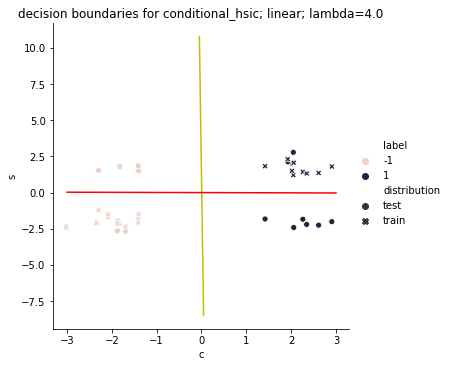

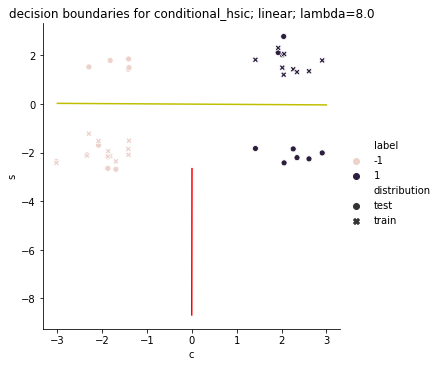

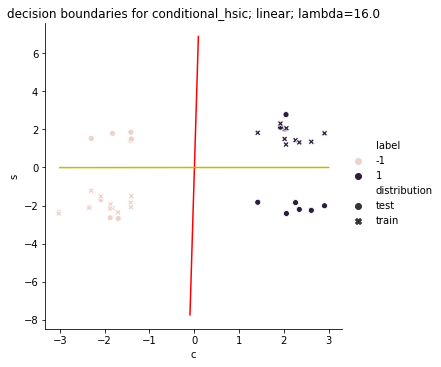

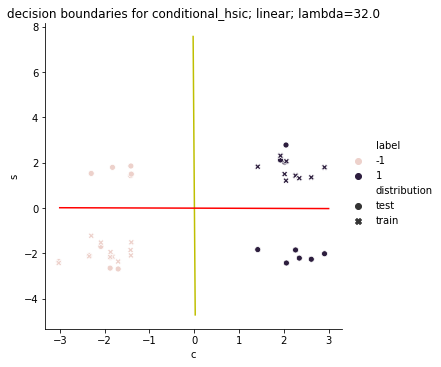

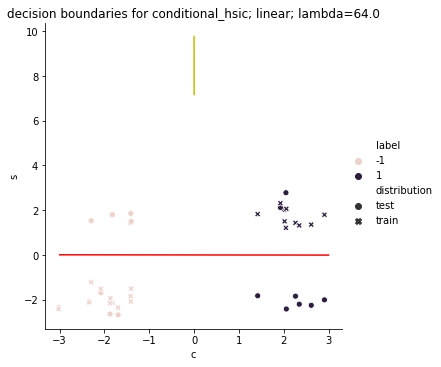

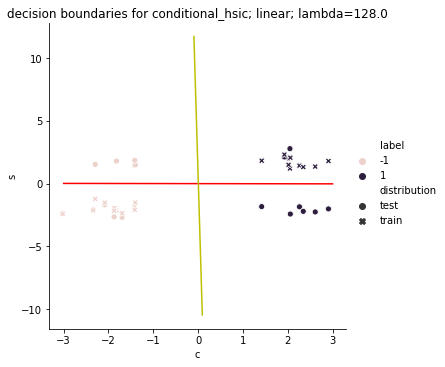

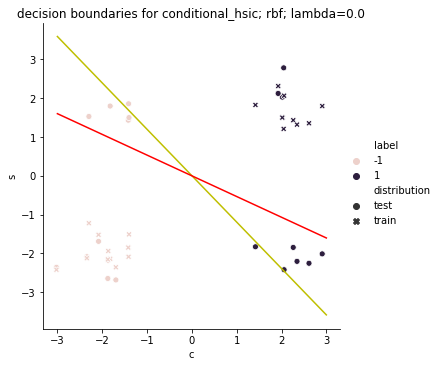

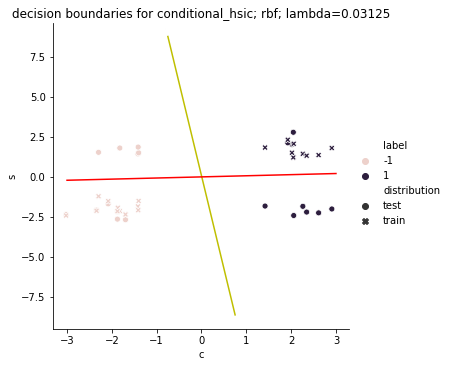

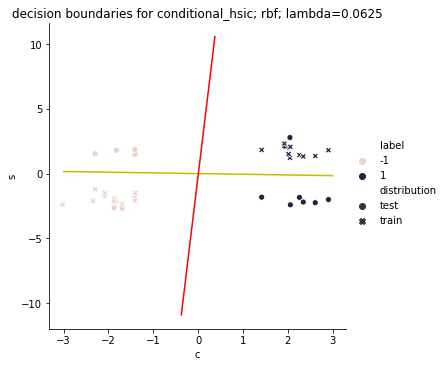

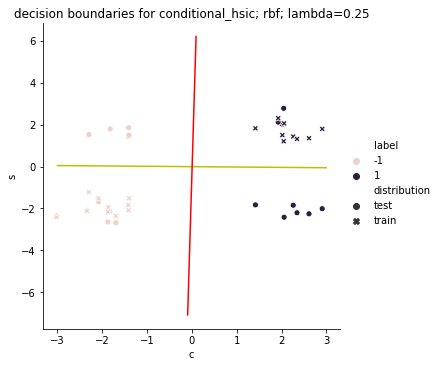

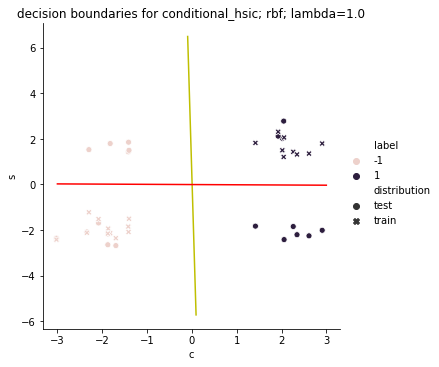

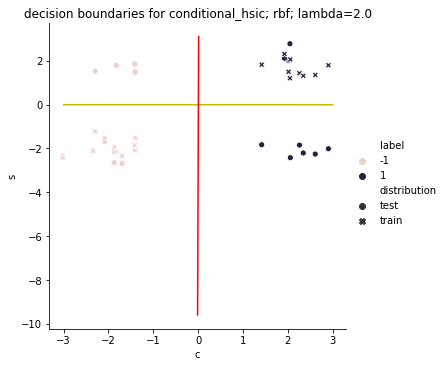

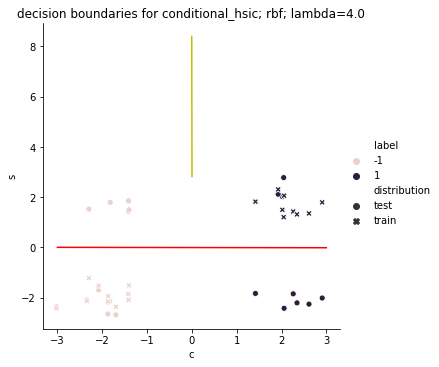

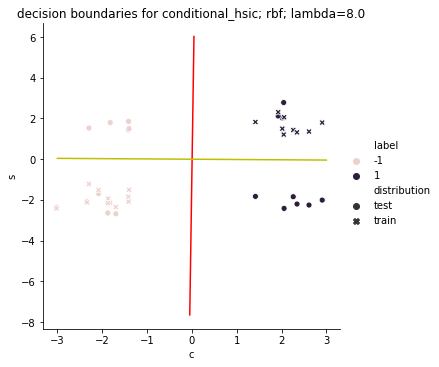

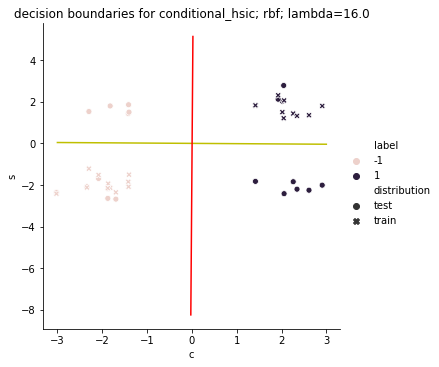

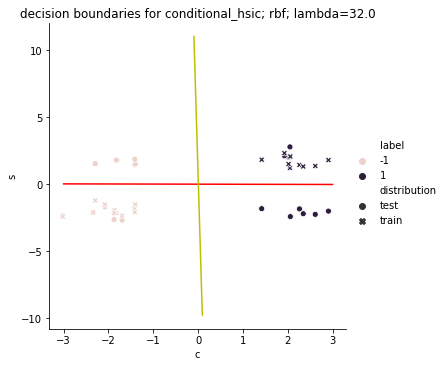

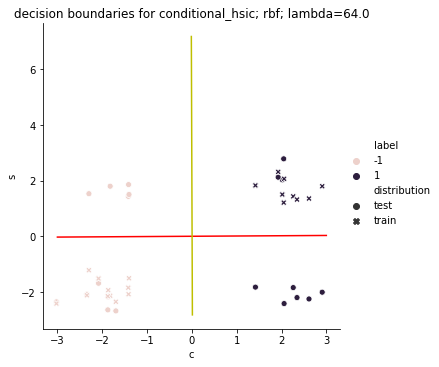

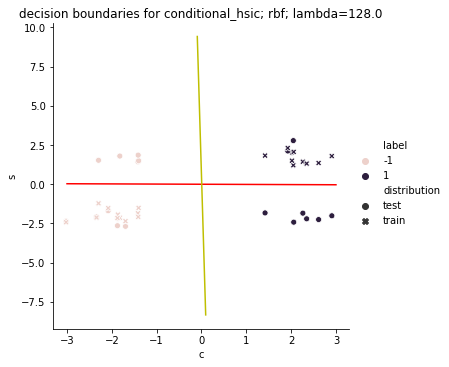

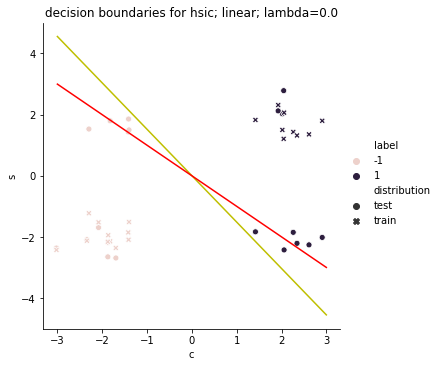

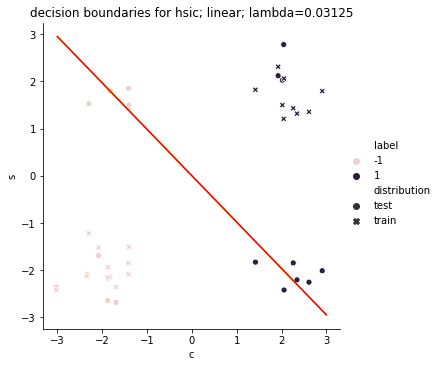

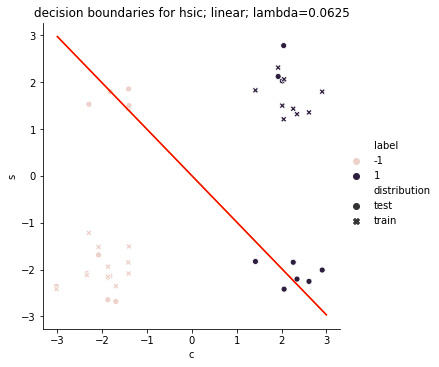

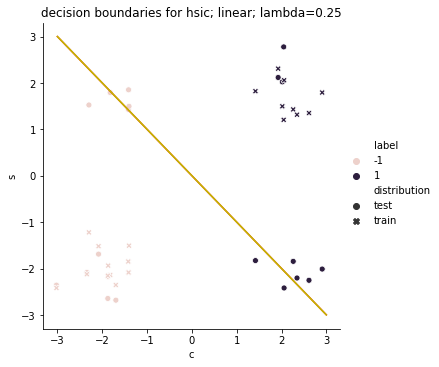

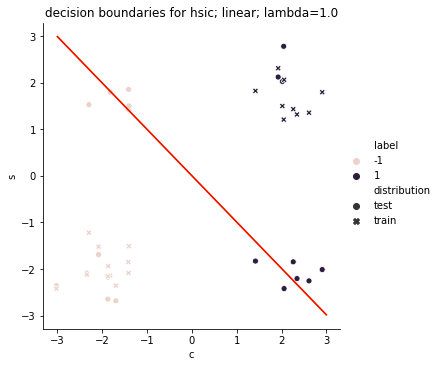

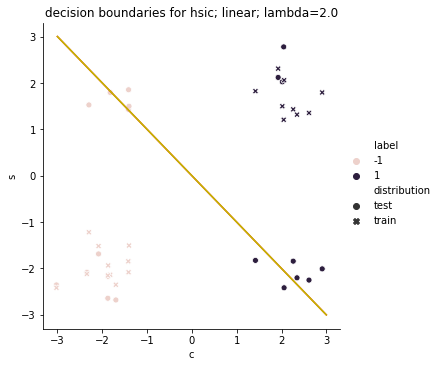

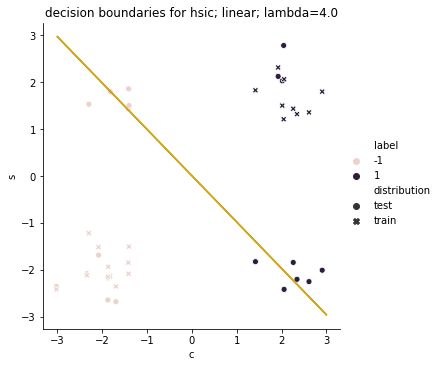

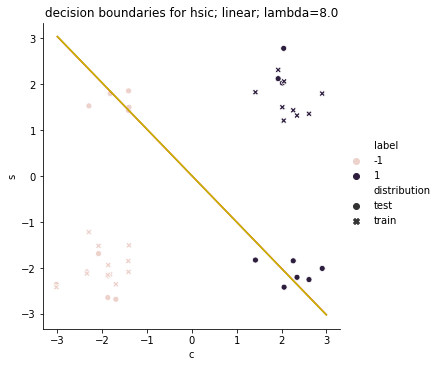

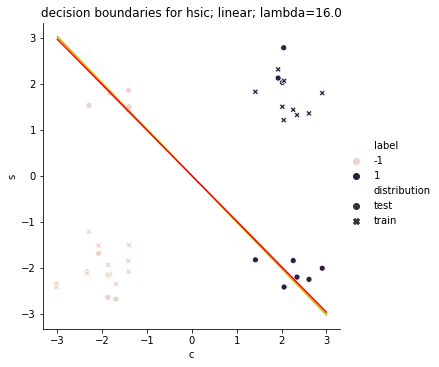

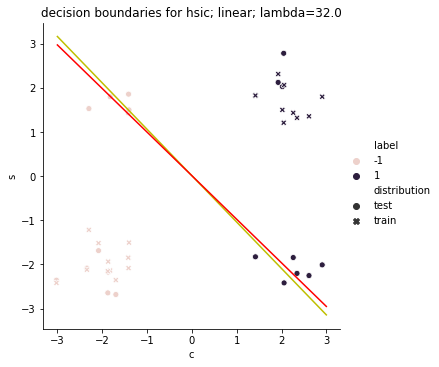

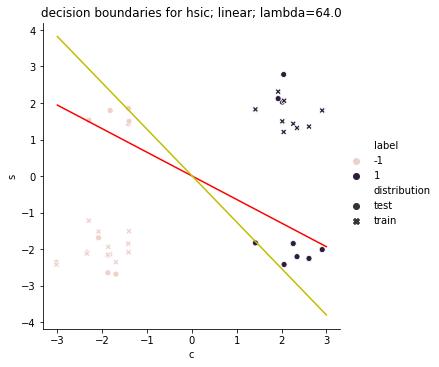

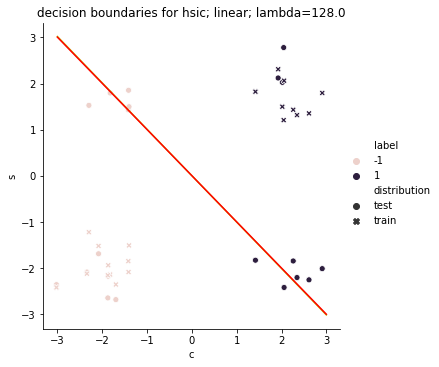

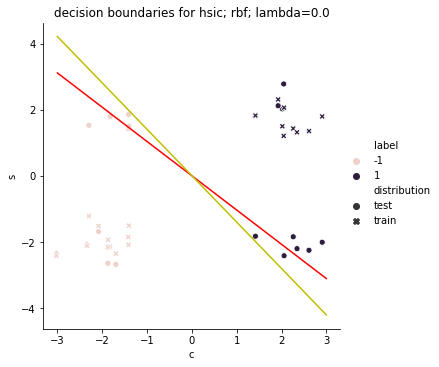

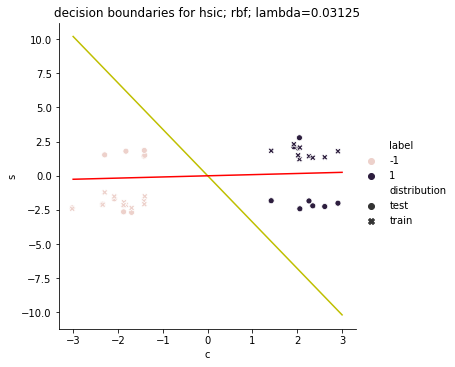

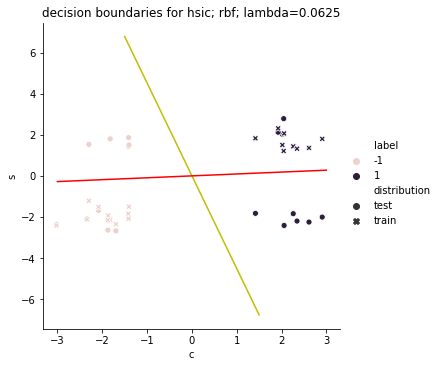

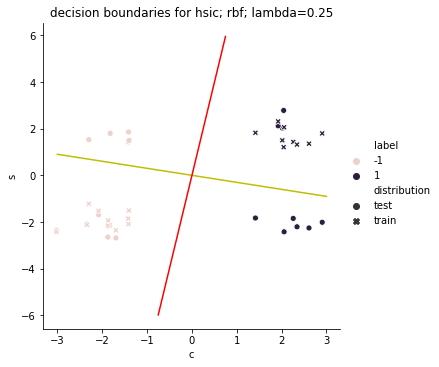

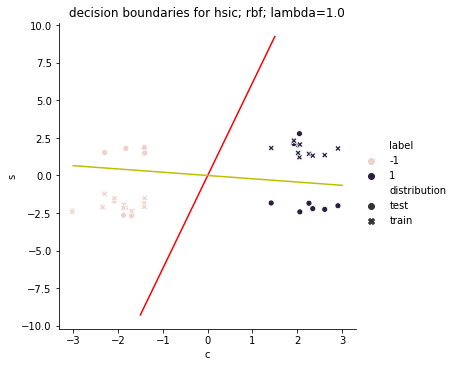

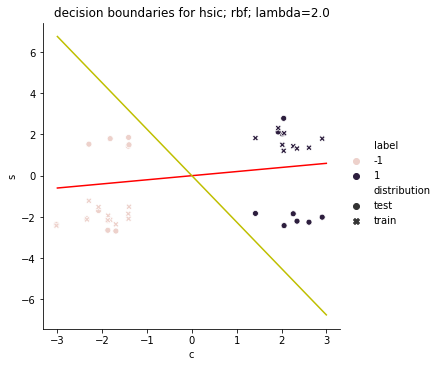

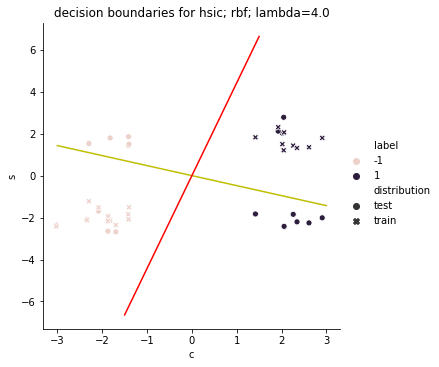

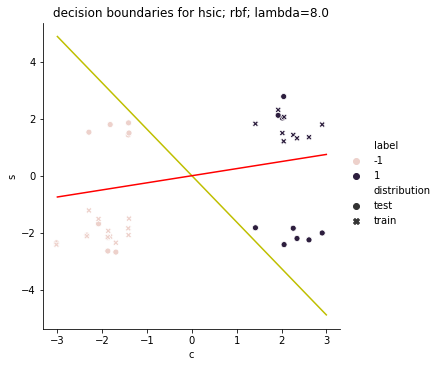

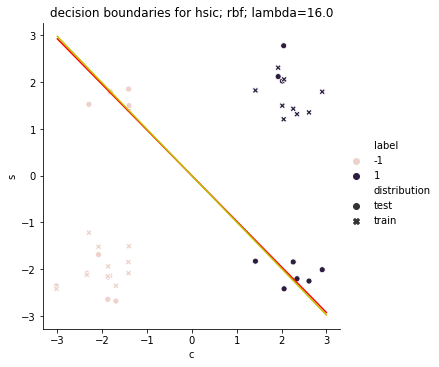

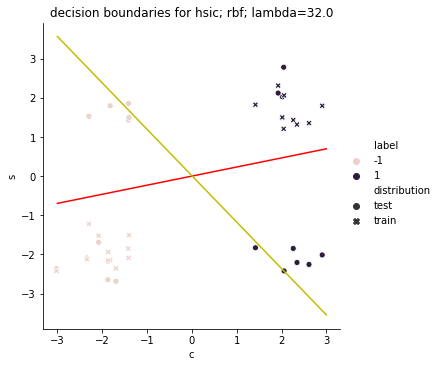

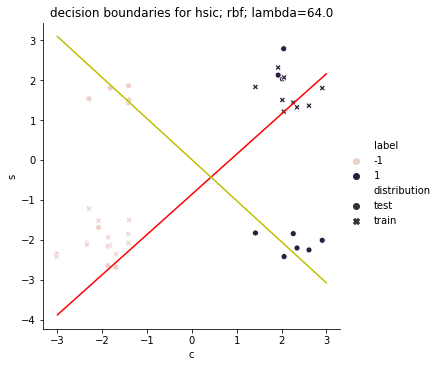

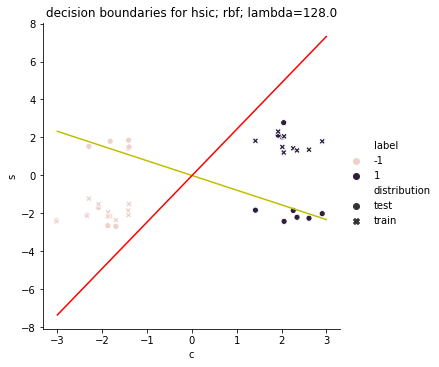

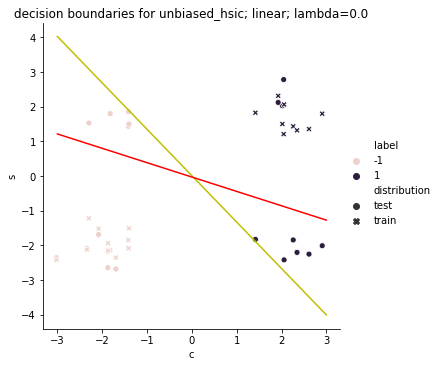

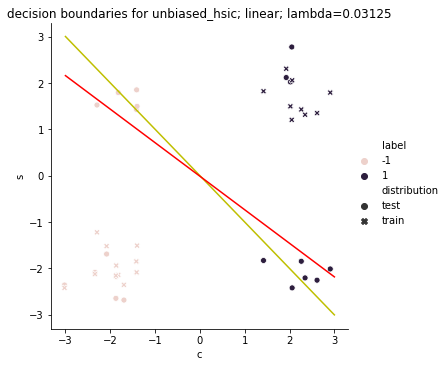

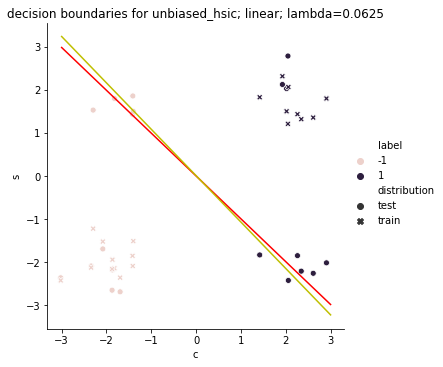

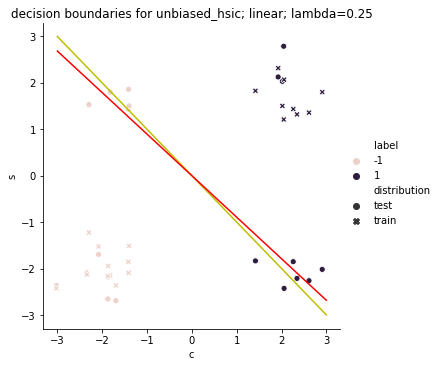

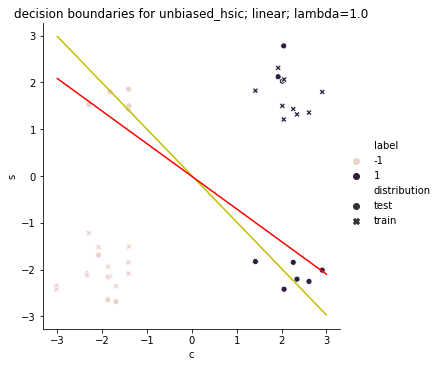

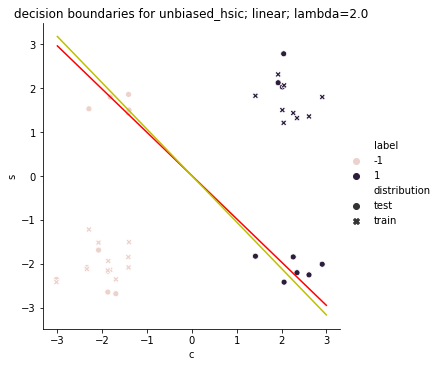

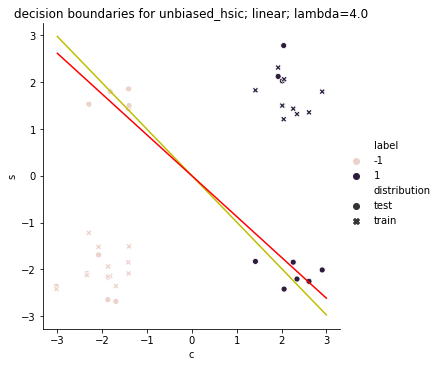

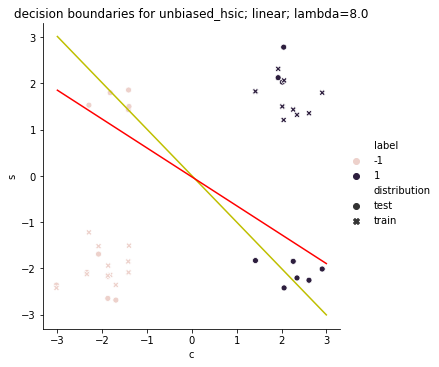

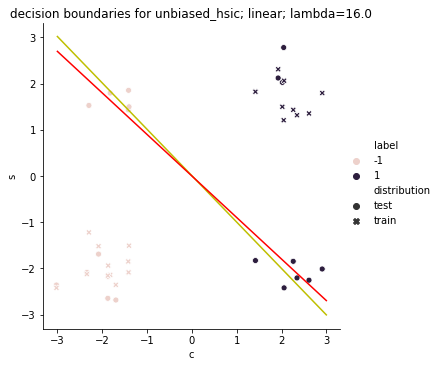

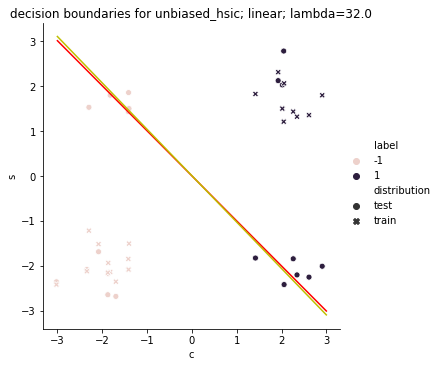

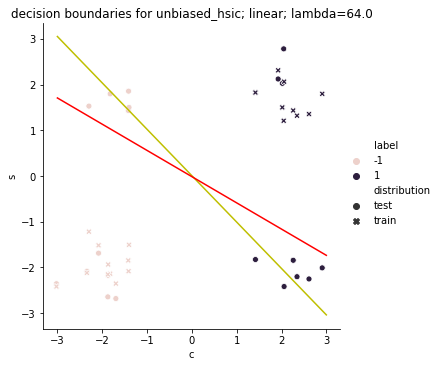

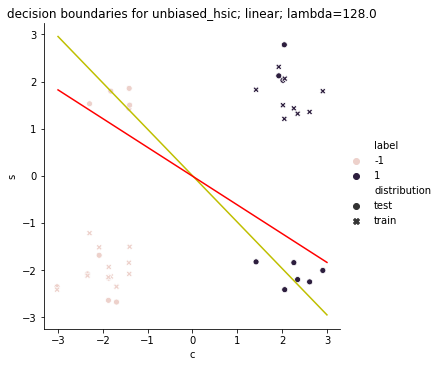

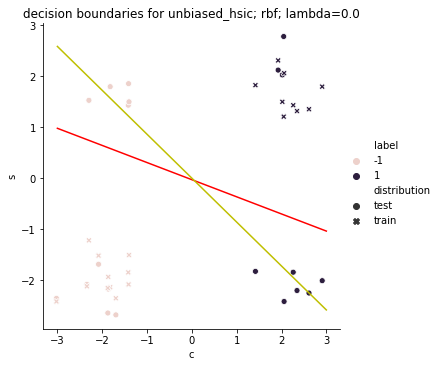

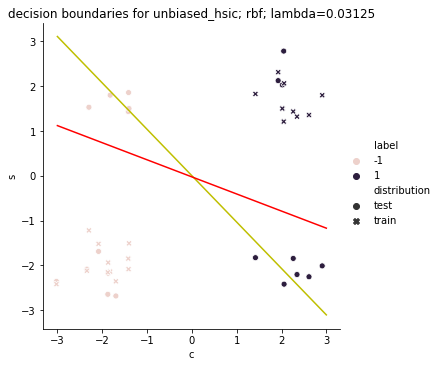

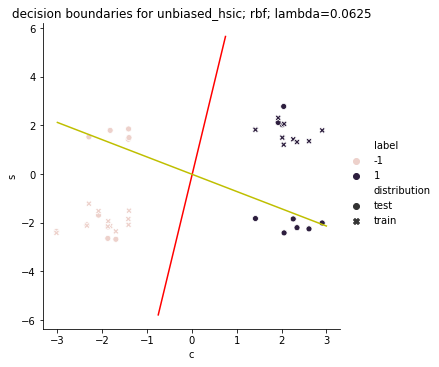

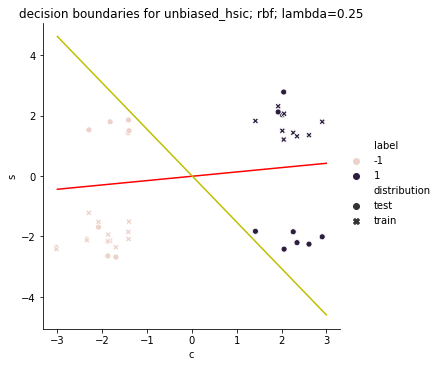

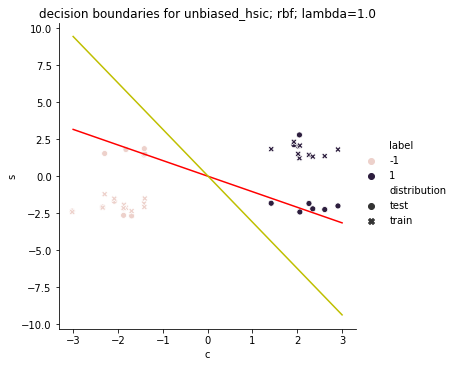

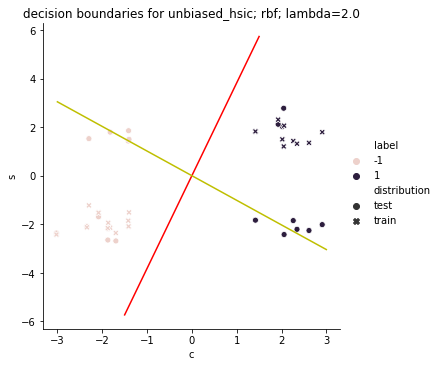

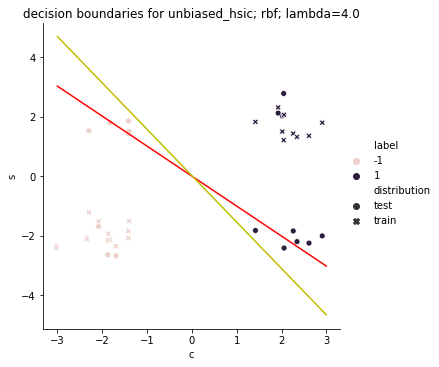

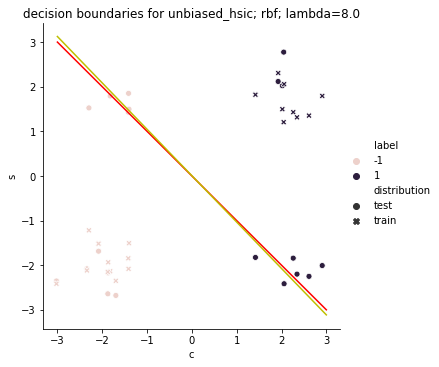

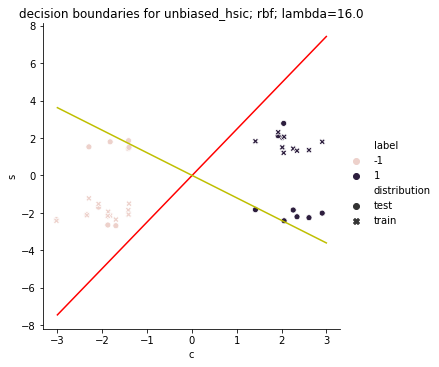

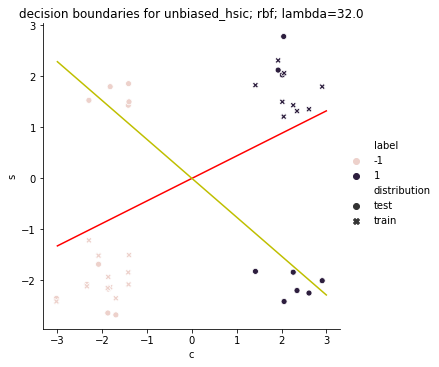

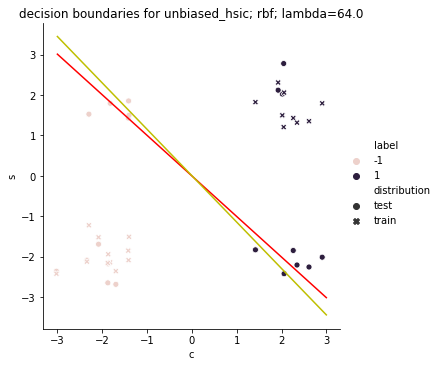

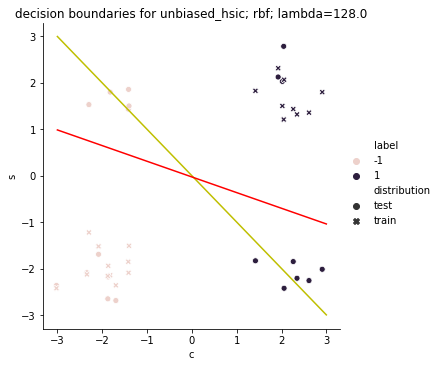

In [10]:
#!/usr/bin/env python3
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


n_samples = 20

sigma_c = 0.4
sigma_s = 0.4

np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(2 * y, scale=sigma_c, size=(n_samples))
z = np.random.choice([1, -1], size=(n_samples))
s = np.random.normal(2 * z, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
test_data = pd.DataFrame(data)
test_data['distribution'] = 'test'


np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(2 * y, scale=sigma_c, size=(n_samples))
s = np.random.normal(2 * y, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
train_data = pd.DataFrame(data)
train_data['distribution'] = 'train'

data = pd.concat([test_data, train_data])
    
def eval_linear_function(a: float, b: float, c: float) -> np.ndarray:
    lim = 3
    while True:
        xs = np.linspace(-lim, lim)
        ys = - 1 / b * (a * xs + c) 
        if np.sum(np.absolute(ys) > 10.0) <= 5 or lim < 0.0001:
            break
        else:
            lim /= 2
    return (xs, ys)


prob = 'toy'

os.makedirs('decision_boundaries', exist_ok=True)

df = TOY_DF.groupby(['indep', 'kernel', 'lambda']).agg(pd.DataFrame.sample)
df = df[['weights']]
df = df.reset_index()

def plot_weights(row: pd.Series):
    weights = row['weights']
    w0, w1 = weights["0"], weights["1"]
    
    net_0 = w0['dense/kernel:0']
    net_0 = net_0 * w0["dense_1/kernel:0"][0][0]

    net_1 = w1['dense_2/kernel:0']
    net_1 = net_1 * w1["dense_3/kernel:0"][0][0]

    xs_0, ys_0 = eval_linear_function(a=net_0[0][0], b=net_0[1][0], c=w0["dense_1/bias:0"])
    xs_1, ys_1 = eval_linear_function(a=net_1[0][0], b=net_1[1][0], c=w1["dense_3/bias:0"])

    plot = sns.relplot(x='c', y='s', hue='label', style='distribution', legend='full', data=data)

    if ys_0[0] > ys_1[0]:
        plt.plot(xs_0, ys_0, 'y-')
        plt.plot(xs_1, ys_1, 'r-')
    else:
        plt.plot(xs_0, ys_0, 'r-')
        plt.plot(xs_1, ys_1, 'y-')

    indep = row['indep']
    kernel = row['kernel']
    lambda_ = row['lambda']
    plot.set(title=f"decision boundaries for {indep}; {kernel}; lambda={lambda_}")
    plot.savefig(f'decision_boundaries/{indep}_{kernel}_lambda{lambda_}.png')
    
df.apply(plot_weights, axis=1)

In [14]:
MNIST_DF = lib_analysis.read_problem(Path('../data'), 'biased_mnist')
MNIST_DF['weights'] = MNIST_DF['weights'].apply(lib_analysis._weights_to_numpy)
MNIST_DF[['cos', 'norm']] = MNIST_DF['weights'].apply(lib_analysis._process_weights_for_cos_and_norm)
MNIST_DF = MNIST_DF.rename(columns={
    "BiasedMnistProblem.training_data_label_correlation": "label_correlation",
    "BiasedMnistProblem.base_model": "model",
})

In [15]:
MNIST_DF = MNIST_DF.rename(columns={
    "BiasedMnistProblem.training_data_label_correlation": "label_correlation",
    "BiasedMnistProblem.base_model": "model",
})

In [16]:
top_level_tabs = []
label_corr = [0.9, 0.999]

for l_corr in label_corr:
    tabs = []
    for indep in sorted(MNIST_DF["indep"].unique()):
        figs = []

        df = MNIST_DF[MNIST_DF["indep"] == indep]
        df = df[df['label_correlation'] == l_corr]
        df = df.copy()
        fig = end_to_end_plot(
            go.Figure(),
            expand_network(df, "norm"),
            "norm",
            ["network", "kernel"],
            "Norms of weights",
        )
        figs.append(fig)

        fig = end_to_end_plot(
            go.Figure(), df, "cos", ["kernel"], "Cos of weights"
        )
        figs.append(fig)

        fig = end_to_end_plot(
            go.Figure(),
            split_train_test(df, "diversity_loss"),
            "diversity_loss",
            ["kernel", "distribution"],
            "Diversity loss",
        )
        figs.append(fig)

        fig = end_to_end_plot(
            go.Figure(),
            split_train_test(expand_network(df, "test_accuracy"), "accuracy"),
            "accuracy",
            ["kernel", "distribution", "network"],
            "Accuracy",
        )
        figs.append(fig)

        tabs.append(dcc.Tab(label=f"{indep} independence", children=[
            dcc.Graph(figure=f) for f in figs
        ]))
    tl_tab = dcc.Tab(label=f"{l_corr} label correlation", children = [dcc.Tabs(children=tabs)])
    top_level_tabs.append(tl_tab)

    
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    dcc.Tabs(top_level_tabs)
])
app.run_server(mode="inline")
